<a href="https://colab.research.google.com/github/elylaila/seminario/blob/main/Distilbert_multi_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00


In [27]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/Seminario

/content/drive/MyDrive/Seminario


# Data loading

In [7]:
df_dev = load_dataset("csv", data_files="dataset/df_train_clean.csv")
# df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [8]:
dev = df_dev['train'].train_test_split(test_size=0.3, seed=42)
dev

DatasetDict({
    train: Dataset({
        features: ['text', 'homotransphobic'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['text', 'homotransphobic'],
        num_rows: 1500
    })
})

In [9]:
df_train = dev["train"]
df_val = dev["test"]

In [10]:
df_train = df_train.rename_column("homotransphobic", "labels")
df_val = df_val.rename_column("homotransphobic", "labels")

# Model loading

In [20]:
nome = 'distilbert_multi_default' # modificare
modello = 'distilbert-base-multilingual-cased'

In [12]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(modello)

# Data preprocessing

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [14]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
# tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

# Training

In [17]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [21]:
config = AutoConfig.from_pretrained(modello)

In [ ]:
# config.dropout = 0.001

In [22]:
print(config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-multilingual-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.33.3",
  "vocab_size": 119547
}



In [23]:
model = AutoModelForSequenceClassification.from_pretrained(modello, config=config)

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [24]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [26]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.589600,0.564348,0.748252
2,0.455200,0.536691,0.771029
3,0.345700,0.621705,0.764782
4,0.222700,0.817779,0.769153
5,0.132800,1.217327,0.748059
6,0.086400,1.212036,0.766114
7,0.030300,1.549122,0.763687
8,0.035400,1.704201,0.744771
9,0.025300,1.715495,0.763833
10,0.013700,1.814080,0.757586


CPU times: user 47min, sys: 38.5 s, total: 47min 38s
Wall time: 52min 4s


TrainOutput(global_step=6570, training_loss=0.1318058197447517, metrics={'train_runtime': 3123.7112, 'train_samples_per_second': 16.807, 'train_steps_per_second': 2.103, 'total_flos': 6954538429440000.0, 'train_loss': 0.1318058197447517, 'epoch': 15.0})

# Evaluation

In [28]:
log_history = trainer.state.log_history

In [38]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df_train = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, index=[0])
    df = pd.concat([df, df_train], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df_val = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, index=[0])
    df = pd.concat([df, df_val], ignore_index=True)
df


,Epoch,Loss,Dataset
0,1,0.589600,Training
1,1,0.564348,Validation
2,2,0.455200,Training
3,2,0.536691,Validation
4,3,0.345700,Training
5,3,0.621705,Validation
6,4,0.222700,Training
7,4,0.817779,Validation
8,5,0.132800,Training
9,5,1.217327,Validation


In [47]:
def parse_log_history(log_history):
    """
    Parse the `log_history` of a Trainer to get the intermediate and final evaluation results.
    """
    idx = 0
    while idx < len(log_history) and "train_runtime" not in log_history[idx]:
        idx += 1

    # If there are no training logs
    if idx == len(log_history):
        idx -= 1
        while idx >= 0 and "eval_loss" not in log_history[idx]:
            idx -= 1

        if idx >= 0:
            return None, None, log_history[idx]
        else:
            return None, None, None

    # From now one we can assume we have training logs:
    train_log = log_history[idx]
    lines = []
    training_loss = "No log"
    for i in range(idx):
        if "loss" in log_history[i]:
            training_loss = log_history[i]["loss"]
        if "eval_loss" in log_history[i]:
            metrics = log_history[i].copy()
            _ = metrics.pop("total_flos", None)
            epoch = metrics.pop("epoch", None)
            step = metrics.pop("step", None)
            _ = metrics.pop("eval_runtime", None)
            _ = metrics.pop("eval_samples_per_second", None)
            _ = metrics.pop("eval_steps_per_second", None)
            _ = metrics.pop("eval_jit_compilation_time", None)
            values = {"Training Loss": training_loss, "Epoch": epoch, "Step": step}
            for k, v in metrics.items():
                if k == "eval_loss":
                    values["Validation Loss"] = v
                else:
                    splits = k.split("_")
                    name = " ".join([part.capitalize() for part in splits[1:]])
                    values[name] = v
            lines.append(values)

    idx = len(log_history) - 1
    while idx >= 0 and "eval_loss" not in log_history[idx]:
        idx -= 1

    if idx > 0:
        eval_results = {}
        for key, value in log_history[idx].items():
            if key.startswith("eval_"):
                key = key[5:]
            if key not in ["runtime", "samples_per_second", "steps_per_second", "epoch", "step"]:
                camel_cased_key = " ".join([part.capitalize() for part in key.split("_")])
                eval_results[camel_cased_key] = value
        return train_log, lines, eval_results
    else:
        return train_log, lines, None


In [60]:
his = parse_log_history(log_history)
his # è una tupla, composta da un dizionario e da una lista di dizionari

({'train_runtime': 3123.7112,
  'train_samples_per_second': 16.807,
  'train_steps_per_second': 2.103,
  'total_flos': 6954538429440000.0,
  'train_loss': 0.1318058197447517,
  'epoch': 15.0,
  'step': 6570},
 [{'Training Loss': 0.5896,
   'Epoch': 1.0,
   'Step': 438,
   'Validation Loss': 0.5643476843833923,
   'F1': 0.7482517482517481},
  {'Training Loss': 0.4552,
   'Epoch': 2.0,
   'Step': 876,
   'Validation Loss': 0.5366914868354797,
   'F1': 0.771029071675533},
  {'Training Loss': 0.3457,
   'Epoch': 3.0,
   'Step': 1314,
   'Validation Loss': 0.6217050552368164,
   'F1': 0.76478228063411},
  {'Training Loss': 0.2227,
   'Epoch': 4.0,
   'Step': 1752,
   'Validation Loss': 0.8177785873413086,
   'F1': 0.7691529797398613},
  {'Training Loss': 0.1328,
   'Epoch': 5.0,
   'Step': 2190,
   'Validation Loss': 1.2173266410827637,
   'F1': 0.7480588917785882},
  {'Training Loss': 0.0864,
   'Epoch': 6.0,
   'Step': 2628,
   'Validation Loss': 1.212036371231079,
   'F1': 0.766114248511

In [61]:
type(his), type(his[0]), type(his[1]), type(his[1][0])

(tuple, dict, list, dict)

In [58]:
df_his = pd.DataFrame(his[1], columns=['Step','Epoch', 'Training Loss', 'Validation Loss', 'F1'])

In [59]:
df_his

,Step,Epoch,Training Loss,Validation Loss,F1
0,438,1.0,0.5896,0.564348,0.748252
1,876,2.0,0.4552,0.536691,0.771029
2,1314,3.0,0.3457,0.621705,0.764782
3,1752,4.0,0.2227,0.817779,0.769153
4,2190,5.0,0.1328,1.217327,0.748059
5,2628,6.0,0.0864,1.212036,0.766114
6,3066,7.0,0.0303,1.549122,0.763687
7,3504,8.0,0.0354,1.704201,0.744771
8,3942,9.0,0.0253,1.715495,0.763833
9,4380,10.0,0.0137,1.814080,0.757586


In [39]:
df.to_html(f'loss_{nome}.html')

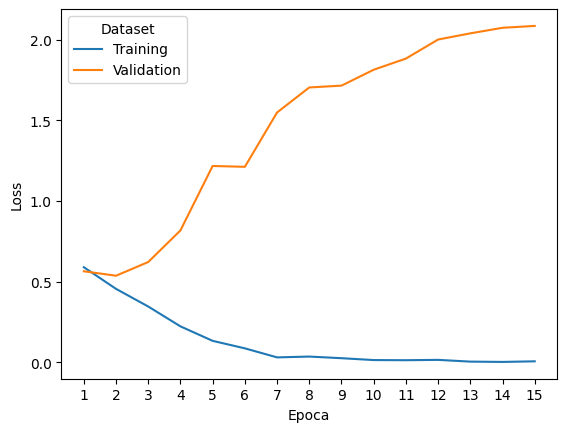

In [40]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
output_predictions = trainer.predict(tokenized_val)

In [42]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       900
           1       0.78      0.66      0.71       600

    accuracy                           0.79      1500
   macro avg       0.78      0.76      0.77      1500
weighted avg       0.79      0.79      0.78      1500



In [43]:
with open(f"class_report_{nome}.html", "w") as file:
    file.write(report)

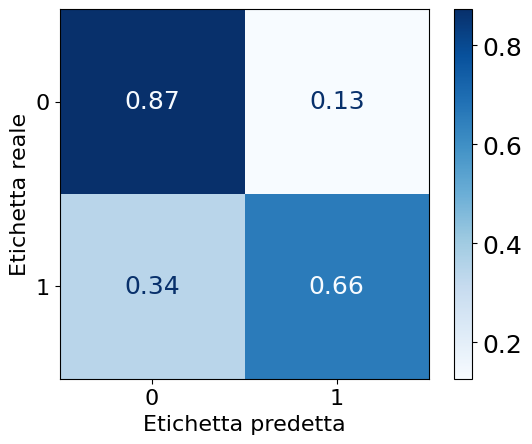

In [44]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()